In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os, sys
import numpy as np
from pygame import mixer, time
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from game_simulation import CoinGameSimulation
from game_browser import CoinGameBrowser
from simulate_strategy import simulate_strategy

pygame 2.1.2 (SDL 2.0.18, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


#
The following code shows the probabilitic graphical model for the coin flip distribution.

### Strategy 4: make use of simple Bayesian reasoning.
This strategy use simple Bayeisan resoning to determine the best strategy to play.

- $p$: The parameter of the Bernoulli distribution of L, is the probability of the opponent being fair.
- $L$:  Bernouilli distribution with unkown parameter p. Determines if the opponent is a cheater or not.
- $\theta$: The parameter of the Bernoulli distribution of H.
- $H_{1:N}$: Bernouilli distribution with parameter $\theta$ and $N$ samples. Gives the number of heads.

We use Bayes rule to get:
$$
\begin{align*}
P(L | H_{1:N}) &= \frac{P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &= \frac{\sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)}{P(H_{1:N})} \\
               &\propto \sum_{\theta=0}^1 P(H_{1:N} | L) \cdot P(L)\\
\end{align*}
$$

We know that:
$$
p = 0.5
$$
$$
\theta=0.5 \text{ if } L=0, \text{ and } \theta=0.75 \text{ if } L=1.
$$
<!--
Meaning that:

 $$
P(\theta | L=0) = 
\begin{cases}
& 1\quad \text{if } \theta=0.5 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

P(\theta | L=1) = 
\begin{cases}
& 1\quad \text{if } \theta=0.75 \\
& 0\quad \text{otherwise} \\
\end{cases} \\

$$ -->

In [11]:
class StrategyBayseian:

    def __init__(self, 
                 threshold = 0.75, 
                 n = 50,
                 flip_5_at_start = False):
        assert 0 <= threshold <= 1
        assert 0 <= n <= 500
        self.threshold = threshold 
        self.flip_5_at_start = flip_5_at_start

        n_heads_array = np.arange(n).reshape(n, 1)
        n_tails_array = np.arange(n)
        p = np.zeros((n, n, 2))
        p[:, :, 0] = 0.5 ** n_heads_array * 0.5 ** n_tails_array
        p[:, :, 1] = 0.75 ** n_heads_array * (1-0.75) ** n_tails_array
        self.p = p / p.sum(axis=2)[:, :, np.newaxis]

    def set_theshold(self, threshold):
        assert 0 <= threshold <= 1
        self.threshold = threshold

    def show_p(self, shape=None):
        if shape is None:
            shape = self.p.shape
        plt.imshow(self.p[:shape[0], :shape[1], 0])
        plt.show()

    def get_p(self):
        return self.p

    def strategy(self, n_heads, n_tails, flips_left):
        if self.flip_5_at_start and n_heads + n_tails == 0 and flips_left >= 5:
            return 1
        
        p = self.p[n_heads, n_tails, :]

        if np.max(p) > self.threshold or flips_left == 0:
            label = np.argmax(p)
            return label + 2
        else:
            return 0

In [12]:
strat = StrategyBayseian(n=500)
g = CoinGameSimulation()
scores = []

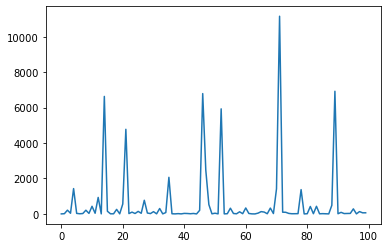

In [13]:
for i in range(100):
    (n_heads, n_tails, flips_left) = g.reset()
    done = False
    while not done:
        action = strat.strategy(n_heads, n_tails, flips_left)
        (n_heads, n_tails, flips_left), reward, done, info = g.step(action)

    score = info["score"]
    scores.append(score)

plt.plot(scores, label="scores")
plt.show()

In [16]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=500)

score 134.674 ± 244.3956786115499
n_labels 163.1 ± 290.5413258040928
n_flips_per_game 1282.476 ± 2281.648376377044
n_flips_per_label 7.863126916002453 ± 4.555386005952751
reward -0.14497632957292506 ± 8.721066511750777


In [19]:
strat.flip_5_at_start

False

In [18]:
strat.set_theshold(0.78)
simulate_strategy(strat.strategy, n_simulations=500)

score 333.874 ± 848.0478796176546
n_labels 411.73 ± 1038.1102817620101
n_flips_per_game 2787.556 ± 7019.858864882114
n_flips_per_label 6.770349500886503 ± 4.874489518127921
reward -0.03598490413173439 ± 6.800930257961998


In [20]:
g = CoinGameBrowser()
log_file = "log_strat4.txt"

In [22]:
with open(log_file, 'w') as f:
    f.write('Score,Flips left,Heads,Tails,Action,Reward\n')

In [47]:
i = 0
try:
    while True:
        if i > 0:
            (n_heads, n_tails, flips_left) = g.reset()
        i += 1
        done = False
        while not done:
            action = strat.strategy(n_heads, n_tails, flips_left)
            (n_heads, n_tails, flips_left), reward, done, info = g.step(action)
            score = info["score"]
            print(f'{score=}, {flips_left=}, {n_heads=}, {n_tails=}, {action=}, {reward=}   ', end='\r')            
            with open(log_file, 'a') as f:
                f.write(f'{score:3},{flips_left:3},{n_heads:2},{n_tails:2},{action:2},{reward:3}\n')
        if score > 200:
            break
except Exception as e:
    print(e)

mixer.init()
while True:
    sound = mixer.Sound("coin-win-notification.wav")
    sound.play()
    time.wait(int(sound.get_length() * 1000))

KeyboardInterrupt: 